
 Mehran Rahnamania  - 400206251

 HW2_2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import seaborn as sns
import os
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/HW2_data/international_matches.csv')

In [ ]:
data[-10:]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


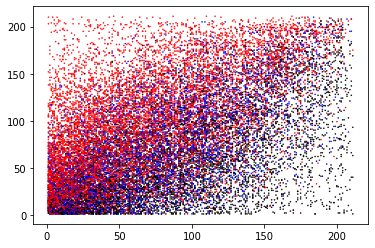

In [ ]:
home_team_fifa_rank = data['home_team_fifa_rank']
away_team_fifa_rank = data['away_team_fifa_rank']
home_team_result = data['home_team_result']

result = np.array(home_team_result)
result[result == 'Win'] = 'r'
result[result == 'Lose'] = 'k'
result[result == 'Draw'] = 'b'

plt.scatter(home_team_fifa_rank, away_team_fifa_rank, s=0.3, c=result)

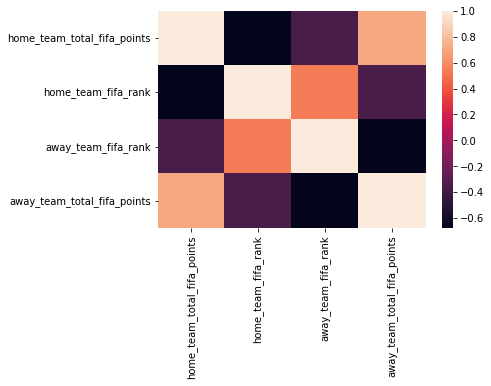

In [ ]:
data1 = data[['home_team_total_fifa_points', 'home_team_fifa_rank',
              'away_team_fifa_rank', 'away_team_total_fifa_points', 'home_team_result']]

index = data1[data1['home_team_total_fifa_points'] == 0].index.to_numpy() 
data1 = data1.drop(index).reset_index()

def result(x):
  y = np.zeros(len(x))
  y[list(x[x =='Win'].index)] = 2
  y[list(x[x =='Draw'].index)] = 1
  y[list(x[x =='Lose'].index)] = 0
  y = y.astype('int')
  return y


tr_data = data1[:7224]
tr = tr_data.drop(['home_team_result', 'index'], axis=1)
train_target = result(tr_data['home_team_result'].reset_index(drop=True))



te_data = data1[7224:]
te = te_data.drop(['home_team_result', 'index'], axis=1)
test_target = result(te_data['home_team_result'].reset_index(drop=True))


sns.heatmap(tr.corr())

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
          )


    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
class MyDataset(Dataset):
    def __init__(self, target, train):
        self.train = train.to_numpy()
        self.target = target


    def __len__(self):
        return len(self.target)


    def __getitem__(self, idx):
        train = torch.tensor(self.train[idx], dtype=torch.float, requires_grad=True)
        target = self.target[idx]
        return train, target

In [ ]:
training_data = MyDataset(train_target, tr)
test_data = MyDataset(test_target, te)

train_dataloader = DataLoader(training_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=True)

In [ ]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return 

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [ ]:
epochs = 5
l = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 52.934242  [    0/ 7224]
loss: 1.198069  [  500/ 7224]
loss: 1.007129  [ 1000/ 7224]
loss: 0.834612  [ 1500/ 7224]
loss: 1.130863  [ 2000/ 7224]
loss: 0.954038  [ 2500/ 7224]
loss: 1.054547  [ 3000/ 7224]
loss: 0.700253  [ 3500/ 7224]
loss: 0.594078  [ 4000/ 7224]
loss: 0.976937  [ 4500/ 7224]
loss: 0.907673  [ 5000/ 7224]
loss: 1.050107  [ 5500/ 7224]
loss: 1.066008  [ 6000/ 7224]
loss: 0.814459  [ 6500/ 7224]
loss: 1.148973  [ 7000/ 7224]
Test Error: 
 Accuracy: 60.2%, Avg loss: 0.927971 

Epoch 2
-------------------------------
loss: 0.712714  [    0/ 7224]
loss: 0.923426  [  500/ 7224]
loss: 0.742292  [ 1000/ 7224]
loss: 1.177113  [ 1500/ 7224]
loss: 1.145509  [ 2000/ 7224]
loss: 1.568482  [ 2500/ 7224]
loss: 1.141519  [ 3000/ 7224]
loss: 0.707147  [ 3500/ 7224]
loss: 1.293847  [ 4000/ 7224]
loss: 0.821834  [ 4500/ 7224]
loss: 1.030732  [ 5000/ 7224]
loss: 0.554804  [ 5500/ 7224]
loss: 0.825793  [ 6000/ 7224]
loss: 0.768304  [ 6500/ 722